Stop codons
=======

<h6><a href="javascript:toggle()" target="_self">Toggle source code</a></h6>

In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [2]:
plt.rc('savefig', dpi=150)

In [3]:
%load_ext ipycache

In [4]:
# Other imports
import os
import re
import numpy as np
import pandas as pd
import random
import vcf
from Bio import SeqIO

/homes/marco/nfs/marco/software/anaconda/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarning: Error in objects(db.pos, all.names = TRUE) : 
  2 arguments passed to .Internal(ls) which requires 3

  rpy2.rinterface.initr()


In [5]:
evol = set()
for l in open('../evolution_experiment.txt'):
    evol.add(l.strip())

In [6]:
# Which genes are pseudo?
pseudo = set()
genes = set()
for s in SeqIO.parse('../genome.gbk', 'genbank'):
    for f in s.features:
        if f.type == 'CDS' and 'pseudo' in f.qualifiers:
            pseudo.add( f.qualifiers['locus_tag'][0] )
        if f.type == 'CDS':
            genes.add( f.qualifiers['locus_tag'][0] )

In [12]:
%%cache stop_codons.pkl stop
s = []
for f in [x for x in os.listdir('../pout/') if x.endswith('.stop.vcf')]:
    for r in vcf.Reader(open('../pout/%s'%f)):
        a = [f.split('.')[0], r.INFO['CDS']]
        if r.INFO['CDS'] in pseudo:
            a.append('pseudogene')
        else:
            a.append('gene')
        a.append( float(re.search('[0-9]{1,10}', r.INFO['MUT']).group(0)) )
        if r.INFO['CDS'] in pseudo:
            a.append(np.nan)
        else:
            a.append( float(r.INFO['PROTLEN']) )
        if r.INFO['CDS'] in pseudo:
            a.append(np.nan)
        else:
            a.append( float(re.search('[0-9]{1,10}', r.INFO['MUT']).group(0))/float(r.INFO['PROTLEN']) )
        if r.INFO['CDS'] in pseudo:
            a.append(np.nan)
        else:
            a.append( float(r.INFO['PROTLEN']) - float(re.search('[0-9]{1,10}', r.INFO['MUT']).group(0)) )
        a.append( r.INFO['STOP'] )
        if f.split('_')[0] in evol:
            a.append( 'evolution experiment' )
        else:
            a.append( 'natural isolate' )
        s.append(a)
stop = pd.DataFrame(s)
stop.columns = ['strain', 'gene', 'gene type', 'position', 'protein length',
                'position (%)', 'end distance', 'type', 'strain type']
#stop.set_index('strain', inplace=True)

[Skipped the cell's code and loaded variables stop from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/stop_codons.pkl'.]


In [13]:
%%cache stop_codons_reads.pkl stop1
s = []
for f in [x for x in os.listdir('../mout/') if x.endswith('.stop.vcf')]:
    for r in vcf.Reader(open('../mout/%s'%f)):
        a = [f.split('.')[0], r.INFO['CDS']]
        if r.INFO['CDS'] in pseudo:
            a.append('pseudogene')
        else:
            a.append('gene')
        a.append( float(re.search('[0-9]{1,10}', r.INFO['MUT']).group(0)) )
        if r.INFO['CDS'] in pseudo:
            a.append(np.nan)
        else:
            a.append( float(r.INFO['PROTLEN']) )
        if r.INFO['CDS'] in pseudo:
            a.append(np.nan)
        else:
            a.append( float(re.search('[0-9]{1,10}', r.INFO['MUT']).group(0))/float(r.INFO['PROTLEN']) )
        if r.INFO['CDS'] in pseudo:
            a.append(np.nan)
        else:
            a.append( float(r.INFO['PROTLEN']) - float(re.search('[0-9]{1,10}', r.INFO['MUT']).group(0)) )
        a.append( r.INFO['STOP'] )
        if f.split('_')[0] in evol:
            a.append( 'evolution experiment' )
        else:
            a.append( 'natural isolate' )
        s.append(a)
stop1 = pd.DataFrame(s)
stop1.columns = ['strain', 'gene', 'gene type', 'position', 'protein length',
                'position (%)', 'end distance', 'type', 'strain type']
#stop.set_index('strain', inplace=True)

[Saved variables stop1 to file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/stop_codons_reads.pkl'.]


Position of stop gains across the gene
--------------------------------------------

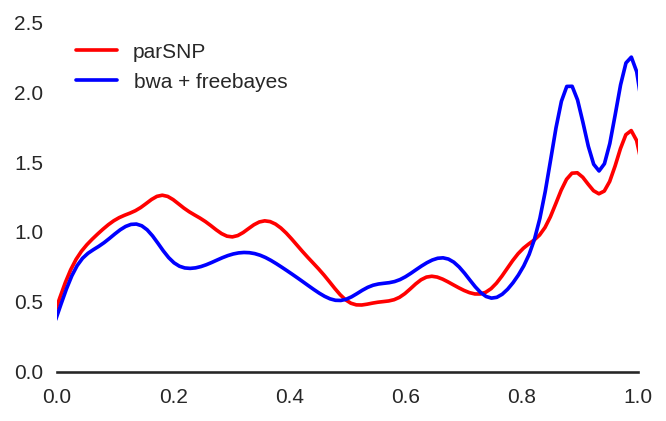

In [23]:
plt.figure(figsize=(5, 3))

sns.kdeplot(stop[(stop['gene type'] == 'gene') &
    (stop['type'] == 'stop_gained') &
    (stop['strain type'] == 'natural isolate')]['position (%)'],
            color='r', bw=.03,
            label='parSNP')
sns.kdeplot(stop1[(stop1['gene type'] == 'gene') &
    (stop1['type'] == 'stop_gained') &
    (stop1['strain type'] == 'natural isolate')]['position (%)'],
            color='b', bw=.03,
            label='bwa + freebayes')
#sns.rugplot(a, alpha=0.05)

plt.xlim(0, 1)

sns.despine(left=True)

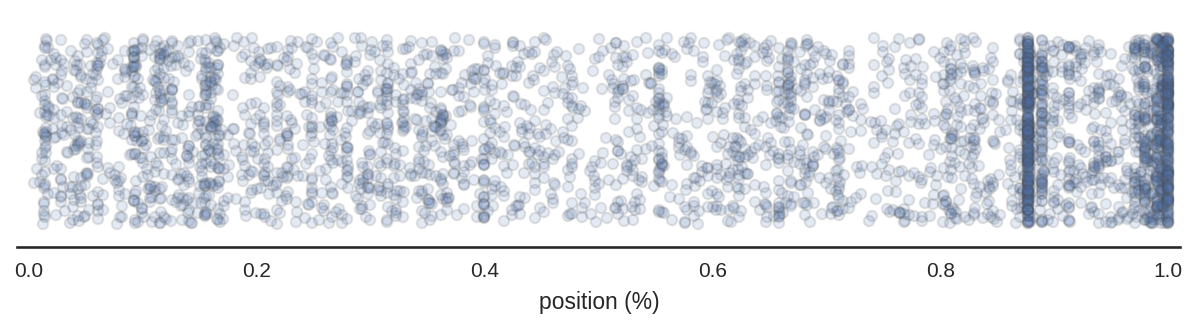

In [18]:
plt.figure(figsize=(10, 2))

sns.stripplot(x='position (%)',
              data=stop1[(stop1['gene type'] == 'gene') &
                        (stop1['type'] == 'stop_gained') &
                        (stop1['strain type'] == 'natural isolate')],
              size=5, jitter=0.4, edgecolor="gray",
              alpha=0.15)

plt.xlim(-0.01, 1.01)
sns.despine(left=True)

Enrichment in pseudogenes
-----------------------------

In [19]:
r = []
for strain in set(stop[stop['strain type'] == 'natural isolate']['strain']):
    lgenes = len(set(stop[stop['strain'] == strain]['gene']))
    
    act = float(len(set(stop[(stop['gene type'] == 'pseudogene') &
     (stop['strain'] == strain)]['gene']))) / len(set(stop[(stop['gene type'] == 'gene') &
     (stop['strain'] == strain)]['gene'])) 

    r.append( ('parSNP', 'natural isolates', act) )
    
    p = 0
    g = 0
    for i in range(lgenes):
        rg = random.choice( list(genes) )
        if rg in pseudo:
            p += 1
        else:
            g += 1
    r.append( ('parSNP', 'random genes', float(p)/g) )
for strain in set(stop1[stop1['strain type'] == 'natural isolate']['strain']):
    lgenes = len(set(stop1[stop1['strain'] == strain]['gene']))
    
    act = float(len(set(stop1[(stop1['gene type'] == 'pseudogene') &
     (stop1['strain'] == strain)]['gene']))) / len(set(stop1[(stop1['gene type'] == 'gene') &
     (stop1['strain'] == strain)]['gene'])) 

    r.append( ('bwa + freebayes', 'natural isolates', act) )
    
    p = 0
    g = 0
    for i in range(lgenes):
        rg = random.choice( list(genes) )
        if rg in pseudo:
            p += 1
        else:
            g += 1
    r.append( ('bwa + freebayes', 'random genes', float(p)/g) )
r = pd.DataFrame(r)
r.columns = ['set', 'comparison', 'pseudogenes / genes ratio']

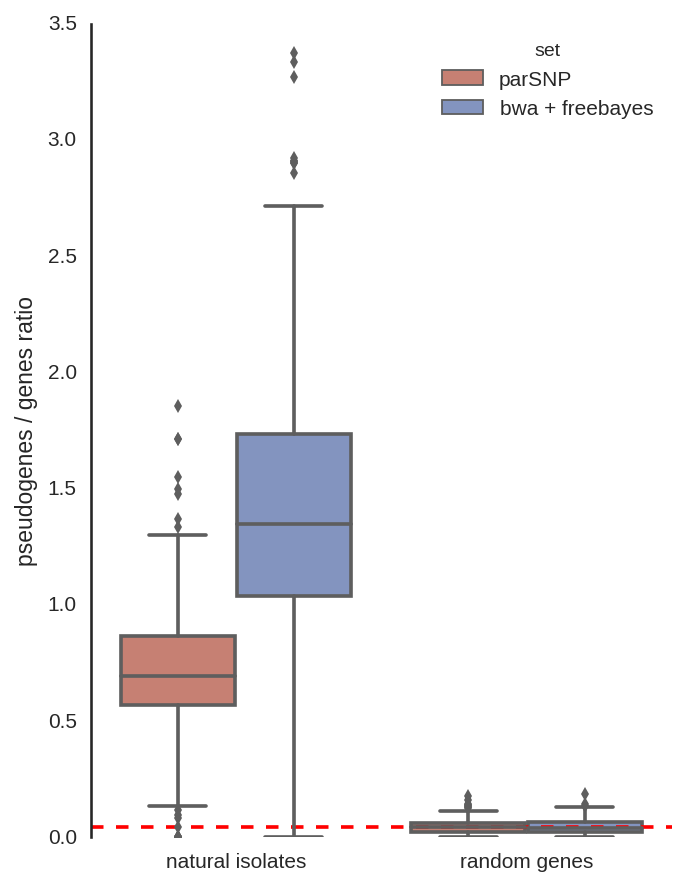

In [24]:
plt.figure(figsize=(5, 7))

sns.boxplot(x='comparison',
            y='pseudogenes / genes ratio',
            hue='set',
            data=r,
            palette=sns.diverging_palette(20, 255, s=50, l=60, n=2))

plt.hlines([float(len(pseudo))/len([x for x in genes if x not in pseudo])],
           -0.5, 1.5,
           colors='r',
           linestyles='dashed')

plt.xlabel('')

sns.despine(bottom=True)